In [1]:
# The dataset contains all historical daily prices (open, high, low, close) for all cryptocurrencies listed on CoinMarketCap.
# Will try to predict the future value for cryptocurrencies

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import datetime
import math
import sklearn
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [160]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('all_currencies.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df.head()

,Unnamed: 0,Symbol,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,,
2015-11-12,0,$$$,0.000013,0.000017,0.000013,0.000017,142.0,NaN
2015-11-13,1,$$$,0.000017,0.000033,0.000016,0.000024,85.0,NaN
2015-11-14,2,$$$,0.000024,0.000053,0.000023,0.000030,131.0,NaN
2015-11-15,3,$$$,0.000030,0.000063,0.000022,0.000035,132.0,NaN
2015-11-16,4,$$$,0.000035,0.000046,0.000032,0.000036,280.0,NaN


In [161]:
# let's createa list of symbols
symbol_list = df['Symbol'].value_counts().index.tolist()
# print(symbol_list)

In [175]:
# check the top cryptocurrencies
df.Symbol.value_counts().head()

BTC    1979
NMC    1979
LTC    1979
PPC    1978
NVC    1978
Name: Symbol, dtype: int64

In [162]:
# Create 2 new columns which captures the percent change in high-low value and open & close price
df['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
df['PRICE_PCT'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

# create Dataframew ith required columns only
df = df[['Symbol','Close','Open','High','Low', 'HL_PCT', 'PRICE_PCT', 'Volume']]
print(df.head())

           Symbol     Close      Open      High       Low      HL_PCT  \
Date                                                                    
2015-11-12    $$$  0.000017  0.000013  0.000017  0.000013   23.529412   
2015-11-13    $$$  0.000024  0.000017  0.000033  0.000016   70.833333   
2015-11-14    $$$  0.000030  0.000024  0.000053  0.000023  100.000000   
2015-11-15    $$$  0.000035  0.000030  0.000063  0.000022  117.142857   
2015-11-16    $$$  0.000036  0.000035  0.000046  0.000032   38.888889   

            PRICE_PCT  Volume  
Date                           
2015-11-12  30.769231   142.0  
2015-11-13  41.176471    85.0  
2015-11-14  25.000000   131.0  
2015-11-15  16.666667   132.0  
2015-11-16   2.857143   280.0  


In [163]:
# Check if our required columns has any null values
df.isnull().values.any() # It is true

# count how many null values
df.apply(lambda x: sum(x.isnull()),axis=0)

Symbol          0
Close           0
Open            0
High            0
Low             0
HL_PCT          0
PRICE_PCT       0
Volume       5335
dtype: int64

In [164]:
#check which rows has null values for Condition columns 
data=df.reset_index()
data['year']=data['Date'].dt.year
data.head()
#data[data['Volume'].isnull()]['year'].unique()

,Date,Symbol,Close,Open,High,Low,HL_PCT,PRICE_PCT,Volume,year
0,2015-11-12,$$$,0.000017,0.000013,0.000017,0.000013,23.529412,30.769231,142.0,2015
1,2015-11-13,$$$,0.000024,0.000017,0.000033,0.000016,70.833333,41.176471,85.0,2015
2,2015-11-14,$$$,0.000030,0.000024,0.000053,0.000023,100.000000,25.000000,131.0,2015
3,2015-11-15,$$$,0.000035,0.000030,0.000063,0.000022,117.142857,16.666667,132.0,2015
4,2015-11-16,$$$,0.000036,0.000035,0.000046,0.000032,38.888889,2.857143,280.0,2015


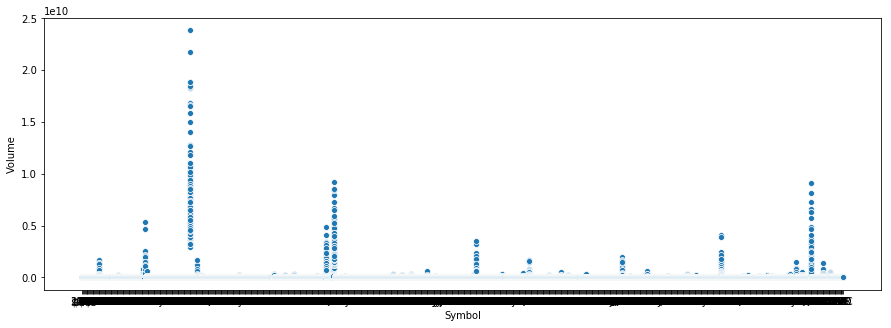

In [8]:
# since we are having data from 2013, so initial volume was not recorded, hence it is null
# Lets check for 2018 
plt.figure(figsize=(15,5))
sns.scatterplot(x="Symbol",y="Volume", data=data.loc[data.year.isin([2018])])

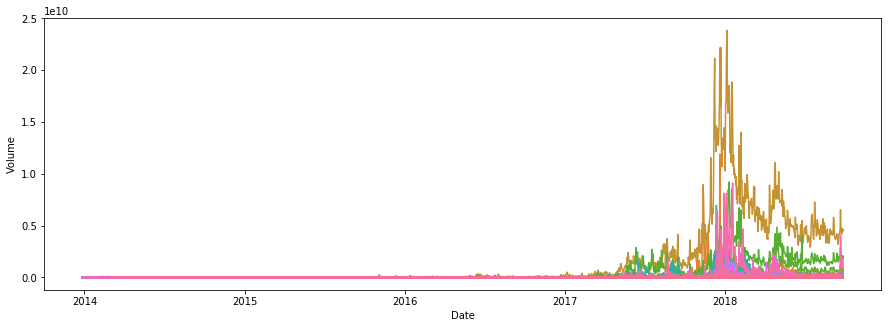

In [9]:
# let's check the volume statistics
plt.figure(figsize=(15,5))
sns.lineplot(x="Date",y="Volume", hue="Symbol", data=df.reset_index(),legend=False)
# from the below graph we can say that after 2017 only crytocurrency market started rising, so let's analyze only that

In [165]:
# we will exclude 2013 null data and for 2018 Null values, will replace with -99999
# With many ML classifiers, it will just be recognized and treated as an outlier feature. 
df.fillna(value=-9999, inplace=True)
# or you can drop all null values but you will miss lots of data then
# df=df.dropna(how='all')

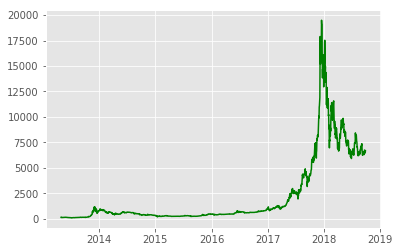

In [166]:
# we will see how Bitcoin performed over the years
plt.plot(df.loc[df['Symbol'] == 'BTC',['Close']], c='g')

In [180]:
# Define Dataframe for each Symbol, for which values has to predict
def create_df(symbol):
    df1=df.loc[(df['Symbol'] == symbol ) & (pd.to_datetime(df.index).year >= 2017)] 
    return df1

df_per_Symbol = create_df('BTC')
df_per_Symbol.head()

,Symbol,Close,Open,High,Low,HL_PCT,PRICE_PCT,Volume
Date,,,,,,,,
2017-01-01,BTC,998.33,963.66,1003.08,958.70,4.445424,3.597742,147775008.0
2017-01-02,BTC,1021.75,998.62,1031.39,996.70,3.395155,2.316196,222184992.0
2017-01-03,BTC,1043.84,1021.60,1044.08,1021.60,2.153587,2.176977,185168000.0
2017-01-04,BTC,1154.73,1044.40,1159.42,1044.40,9.960770,10.563960,344945984.0
2017-01-05,BTC,1013.38,1156.73,1191.10,910.42,27.697409,-12.392693,510199008.0


In [181]:
# features are open price, High/Low difference percent, and the percent change in price (open, close).
# labels are close price, which we will predict
predict_col = 'Close'
predict_out = int(math.ceil(0.05 * len(df_per_Symbol))) # forecast out 2% of the entire length of the dataset, 32 days
predict_out

32

In [182]:
# shift the index (should be date) without realigning the data, label is our feature (coming 40th day value)
df_per_Symbol['label'] = df_per_Symbol[predict_col].shift(-predict_out)
df_per_Symbol.head()

,Symbol,Close,Open,High,Low,HL_PCT,PRICE_PCT,Volume,label
Date,,,,,,,,,
2017-01-01,BTC,998.33,963.66,1003.08,958.70,4.445424,3.597742,147775008.0,1011.80
2017-01-02,BTC,1021.75,998.62,1031.39,996.70,3.395155,2.316196,222184992.0,1029.91
2017-01-03,BTC,1043.84,1021.60,1044.08,1021.60,2.153587,2.176977,185168000.0,1042.90
2017-01-04,BTC,1154.73,1044.40,1159.42,1044.40,9.960770,10.563960,344945984.0,1027.34
2017-01-05,BTC,1013.38,1156.73,1191.10,910.42,27.697409,-12.392693,510199008.0,1038.15


In [183]:
df_per_Symbol.dropna(inplace=True) # drops if still has any NaN
df_model = df_per_Symbol 

X = np.array(df_model.drop(['label','Symbol'], 1)) # features
y = np.array(df_model['label'])   # labels

# Standardize a dataset along any axis, ML methods are more effective if the data attributes have the same scale
X = preprocessing.scale(X)
y = np.array(df_model['label'])

# Let's split our data and check the confidence/accurcay
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# choose Linear Regression classifier
clf = LinearRegression()
clf.fit(X_train, y_train) # train the model
confidence = clf.score(X_test, y_test) # check the confidence
print(confidence)

0.6588492287274543


In [185]:
from sklearn import metrics

y_pred = clf.predict(X_test)
print("Mean absolute error : ", metrics.mean_absolute_error(y_test, y_pred)) # MAE
print("Mean squared error :", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("Root Mean squared error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

Mean absolute error :  1313.5171175510088
Mean squared error : 3817773.525074298
Root Mean squared error:  1953.912363713966


In [172]:
# Let's check the SVM model . From the confidence we can say that SVM is not suited for this dataset
for k in ['linear','poly','rbf','sigmoid']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(k,confidence)

linear 0.47810967129349885
poly 0.14996331880260816
rbf 0.03304543615763067
sigmoid 0.0772665847801548


In [173]:
# Lets forecast the value now.
#  X_last variable contains the most recent features, which we're going to predict against.
df_predict = df_per_Symbol.dropna()
# df_predict.tail()
X = np.array(df_predict.drop(['label','Symbol'], axis=1)) 
X = preprocessing.scale(X)
X_last = X[-predict_out:]
X = X[:-predict_out]
#print(np.isnan(X_last).any())
df_predict.dropna(inplace=True)
y = np.array(df_predict['label'])
y = y[:-predict_out]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = LinearRegression()
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)

predict_values = clf.predict(X_last)
df_predict['Predict_val'] = np.nan

# print(predict_values, confidence, predict_out)

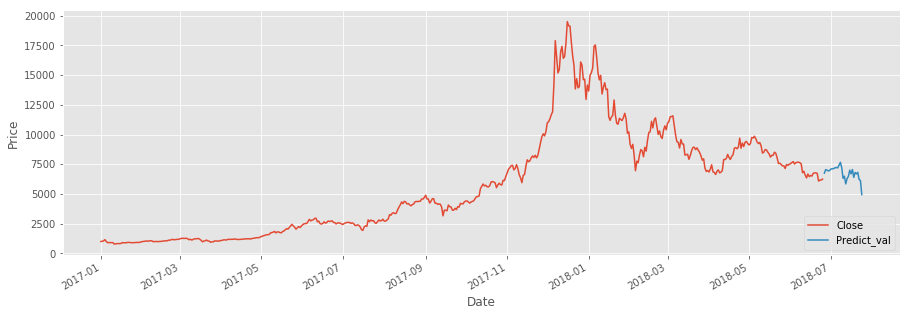

In [158]:
last_date = df_predict.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in predict_values:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df_predict.loc[next_date] = [np.nan for _ in range(len(df_predict.columns)-1)]+[i]

style.use('ggplot')
plt.figure(figsize=(15,5))
df_predict['Close'].plot()
df_predict['Predict_val'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


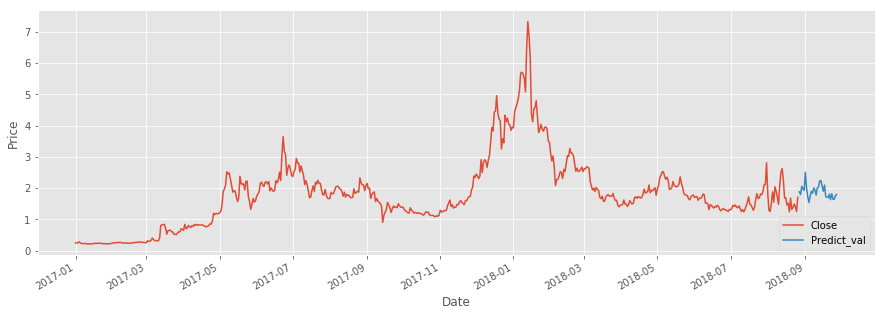

In [178]:
# Let's predict for other cryptocurrency 'NMC'
df_per_Symbol_1 = create_df('NMC')
df_per_Symbol_1['label'] = df_per_Symbol_1[predict_col].shift(-predict_out)

df_predict = df_per_Symbol_1.dropna()
X = np.array(df_predict.drop(['label','Symbol'], axis=1)) 
X = preprocessing.scale(X)
X_last = X[-predict_out:]
X = X[:-predict_out]
df_predict.dropna(inplace=True)
y = np.array(df_predict['label'])
y = y[:-predict_out]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = LinearRegression()
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)

predict_values = clf.predict(X_last)
df_predict['Predict_val'] = np.nan

last_date = df_predict.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in predict_values:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df_predict.loc[next_date] = [np.nan for _ in range(len(df_predict.columns)-1)]+[i]

style.use('ggplot')
plt.figure(figsize=(15,5))
df_predict['Close'].plot()
df_predict['Predict_val'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [ ]:
# AttributeError: 'Series' object has no attribute 'datetime'
# ValueError: Input contains NaN, infinity or a value too large for dtype('float64').